# Assessment 2 - Practical Data Analysis Course
## Rishabh Jain - CID: 02423009 

<hr style="border:2px solid gray">

# Covid 19 Time Series Analysis


# Outline of my solution <a name='index'></a>
1. [Professor's input](#prof.)
1. [Understanding the Data](#Understanding)
1. [Data Visualisation](#visualisation)
1. [Data Preprocessing](#processing)
1. [Defining the problem](#define)
1. [ARIMA modelling](#arima)
1. [Finding the best model](#model)
1. [Conclusion](#conclusion)
1. [References](#references)
1. [Extra work - Multiple Linear Regression](#extra)

<pre><h1 align="center"> 


1.Professor's Input code

(Commented my Inferences with markdown boxes)

</pre>


<hr style="border:2px solid gray">

# Introduction to the problem and the data  <a name="prof."></a> 

Guide for developers for the API involved

https://coronavirus.data.gov.uk/details/developers-guide/main-api

Guide for playing around with markdown language

https://www.ibm.com/docs/en/watson-studio-local/1.2.3?topic=notebooks-markdown-jupyter-cheatsheet

<hr style="border:2px solid gray">


# 1.A  Installing dependencies 

In [3]:
#Installing all the libraries needed at a later point here
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pylab as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
#To show plots inline
%matplotlib inline

#Storing the date formatter, which we will be using later in our plots
weeks = mdates.WeekdayLocator()
years = mdates.YearLocator()
months = mdates.MonthLocator()
weekdays = mdates.DayLocator()
dateFmt = mdates.DateFormatter('%b-%y')

In [4]:
#seaborn is a useful package for handling graphics and 
#producing publication quality images with better colour schemes
import seaborn as sns
sns.set()
sns.set_style("white")
sns.set_context("talk")
#sns.set(font_scale=1.5) 
#sns.set_context("poster")

plt.rcParams.update({'font.size': 32})
plt.rcParams.update({'lines.linewidth':3})

## 1.B  Data Acquisiton - Importing UK COVID metrics data

Next we can import the API package to download government covid metrics

Package install e.g.: `pip install uk-covid19`. If you are having trouble installing this I can provide the data.

This package is an interface to the UK government https://coronavirus.data.gov.uk/

We will use covid metrics as the dependent variables or outcomes in the regression problem.

In [5]:
from uk_covid19 import Cov19API

In [6]:
#Admin hierarchy of data (can also be regional and local)
areaType = 'nation'
area_filter = ['areaType={}'.format(areaType)]

#Form the API query
query = { "areaType":"areaType" ,"areaName":"areaName" ,"areaCode":"areaCode","specimenDate":"date"
         ,"dailyLabConfirmedCases":"newCasesBySpecimenDate","hospital":"hospitalCases"
         ,"newAdmissions":"newAdmissions","deaths":"newDeaths28DaysByDeathDate"
        }
api_query = Cov19API(filters=area_filter, structure=query)

#return a pandas dataframe. Other formats can be used e.g. JSON etc.
df = api_query.get_dataframe()

#rename columns
df.columns = ['Area type', 'Area name', 'Area code', 'Date', 'Cases','Hospital', 'Admissions', 'Deaths']
#Re-index by date
df.set_index(pd.to_datetime(df['Date'], format='%Y-%m-%d'),inplace=True)
df.sort_index(inplace=True)
df

,Area type,Area name,Area code,Date,Cases,Hospital,Admissions,Deaths
Date,,,,,,,,
2020-01-30,nation,England,E92000001,2020-01-30,1.0,NaN,NaN,NaN
2020-01-31,nation,England,E92000001,2020-01-31,0.0,NaN,NaN,NaN
2020-02-01,nation,England,E92000001,2020-02-01,0.0,NaN,NaN,NaN
2020-02-02,nation,England,E92000001,2020-02-02,1.0,NaN,NaN,NaN
2020-02-03,nation,England,E92000001,2020-02-03,18.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-11-06,nation,England,E92000001,2023-11-06,740.0,NaN,NaN,NaN
2023-11-07,nation,England,E92000001,2023-11-07,681.0,NaN,NaN,NaN
2023-11-07,nation,Wales,W92000004,2023-11-07,18.0,NaN,NaN,0.0


#### As Asked for in the question by the Professor, I am making  a rolling average plot here

#### I have not removed periodic systemics from the entire data, as it isn't needed as I am using ARIMA models which automatically account for them in the d parameter

In [7]:
#Select just England data but Wales, Scoltand, and Northern Ireland can also be chosen
df_Eng = df[df['Area name']=='England'].copy()
r=df_Eng.rolling(window=7)
df_Eng_rolling=r.mean(7)

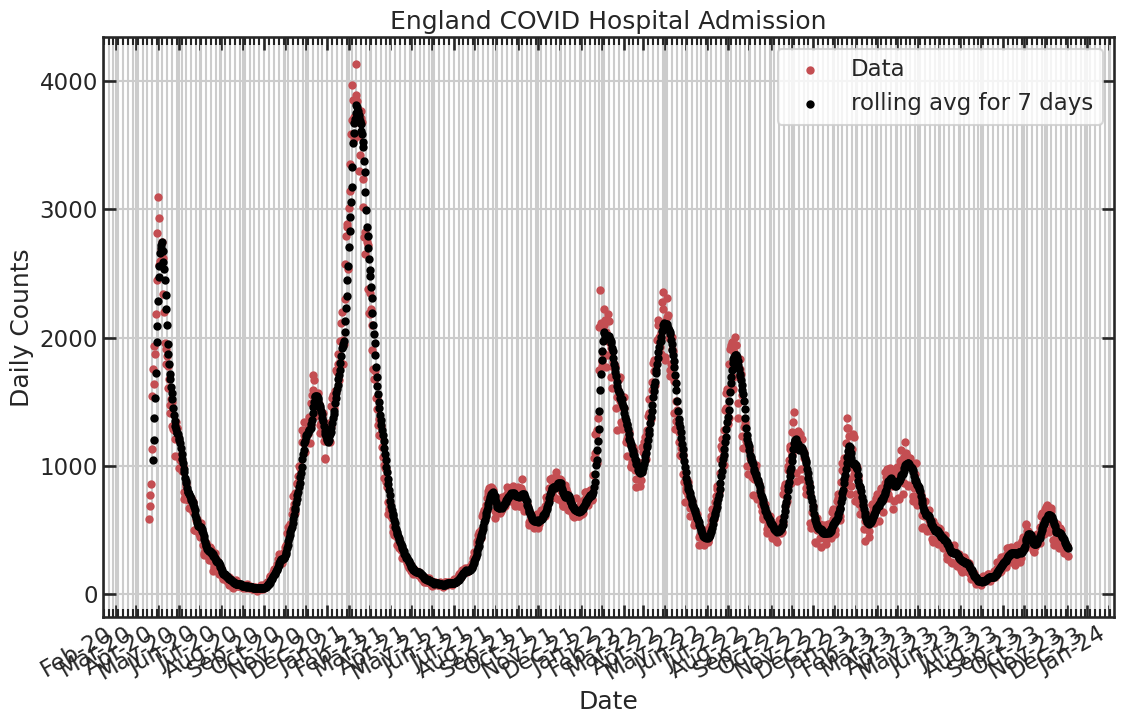

In [8]:
#Plot up some data
fig, ax = plt.subplots(figsize=(12,8),sharex= True, facecolor='white')

ax.scatter(df_Eng.index,df_Eng['Admissions'],label='Data',marker='.',c='C3')
ax.scatter(df_Eng_rolling.index,df_Eng_rolling['Admissions'],label='rolling avg for 7 days',marker='.',c='black')


#Make it pretty
ax.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)

#ax.set_ylim(bottom=0)
ax.grid(which='both')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Counts')

# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFmt)
ax.xaxis.set_minor_locator(weeks)
#ax.set_xlim(left=dt.datetime(2021,7,1))
ax.set_title('England COVID Hospital Admission')
ax.legend()

_= fig.autofmt_xdate()

plt.tight_layout()
plt.savefig('example.png')

For visualisation purposes it is often useful to take rolling averages of the noisy data.

- Add a 7-day rolling average of the hospital admissions column to the plot. See `DataFrame.rolling()` for a native method.

## 1.C Predictors - Google Data

In principle, covid cases, hospital admissions, and deaths are time-lagged outcomes of covariates or "predictor variables" such as the level of interactions in the population, mobility metrics, levels of restrictions etc.

A data set which is often used as a possible predictor is google mobility metrics https://www.google.com/covid19/mobility/.

In [9]:
#Import the data from Google.
#This is a large file!

df_google = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv')



/tmp/ipykernel_8879/3032609671.py:4: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_google = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv')


In [10]:
#Select `United Kingdom` from the full data.
df_google = df_google[df_google['country_region']=='United Kingdom']


df_google = df_google[df_google['sub_region_1'].isnull()]

In [11]:
#Re-index by data
df_google.set_index(pd.to_datetime(df_google['date']),inplace=True)
df_google.sort_index(inplace=True)
df_google.columns

Index(['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2',
       'metro_area', 'iso_3166_2_code', 'census_fips_code', 'place_id', 'date',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')

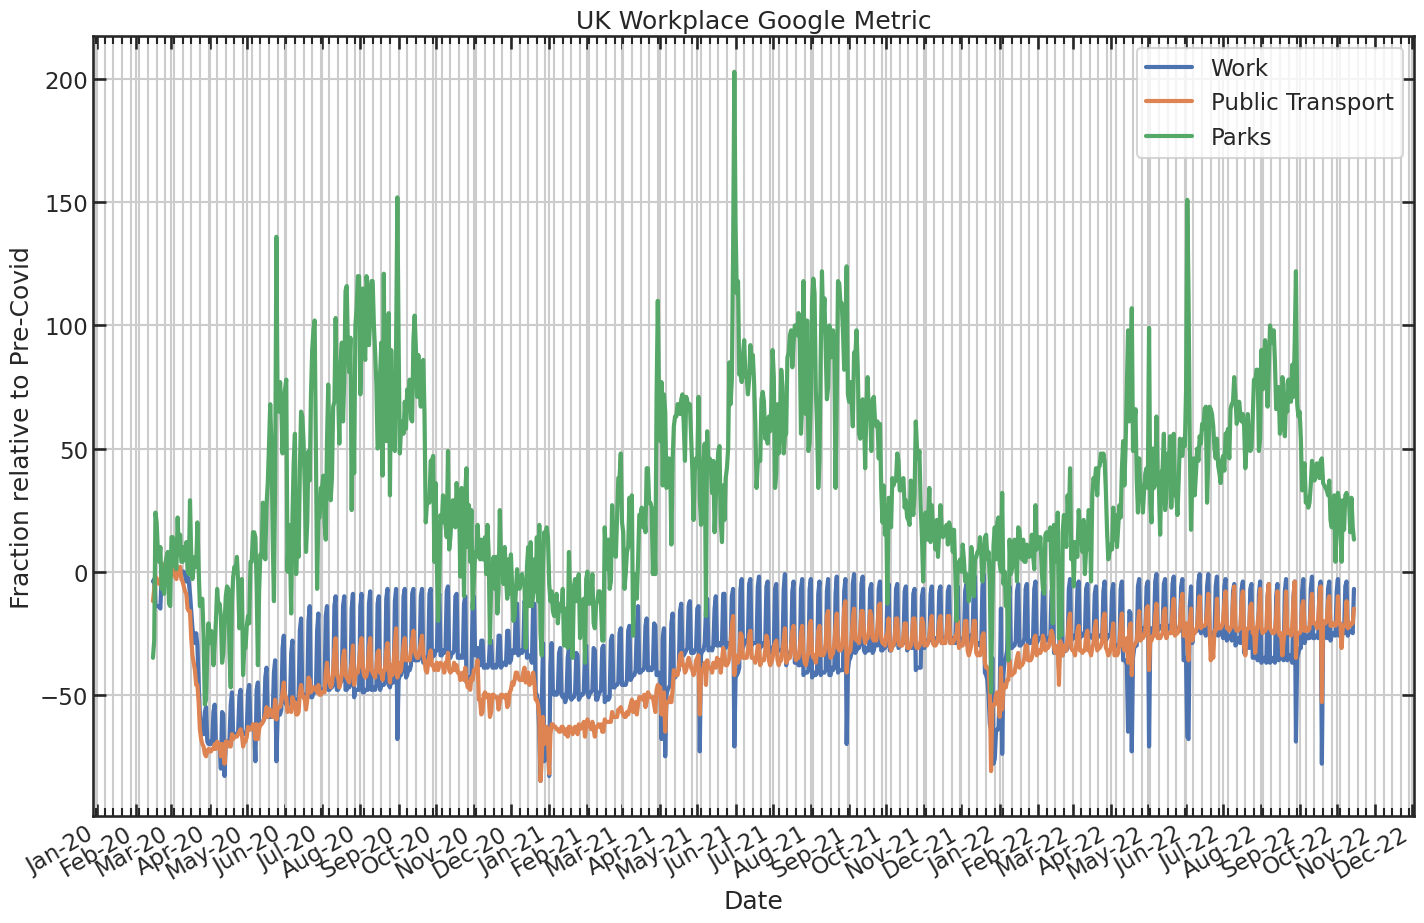

In [12]:
fig, ax = plt.subplots(figsize=(15,10),sharex= True, facecolor='white')

ax.plot(df_google.index,df_google['workplaces_percent_change_from_baseline'],label='Work')
ax.plot(df_google.index,df_google['transit_stations_percent_change_from_baseline'],label='Public Transport')
ax.plot(df_google.index,df_google['parks_percent_change_from_baseline'],label='Parks')


ax.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)

ax.grid(which='both')
ax.set_xlabel('Date')
ax.set_ylabel('Fraction relative to Pre-Covid')

# format the ticks

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFmt)
ax.xaxis.set_minor_locator(weeks)
#ax.set_xlim(left=dt.datetime(2021,7,1))
ax.set_title('UK Workplace Google Metric')
ax.legend()

_= fig.autofmt_xdate()

plt.tight_layout()
plt.savefig('mobility.png')

In [13]:
df_google

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
date,,,,,,,,,,,,,,,
2020-02-15,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-15,-12.0,-7.0,-35.0,-12.0,-4.0,2.0
2020-02-16,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-16,-7.0,-6.0,-28.0,-7.0,-3.0,1.0
2020-02-17,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-17,10.0,1.0,24.0,-2.0,-14.0,2.0
2020-02-18,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-18,7.0,-1.0,20.0,-3.0,-14.0,2.0
2020-02-19,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-19,6.0,-2.0,8.0,-4.0,-14.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-11,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2022-10-11,-11.0,7.0,29.0,-21.0,-24.0,5.0
2022-10-12,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2022-10-12,-11.0,6.0,16.0,-22.0,-24.0,5.0
2022-10-13,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2022-10-13,-9.0,9.0,30.0,-21.0,-24.0,5.0


## 1. D Exercise / Problem Statement

- "Clean" the data of periodic systematics.
- Experiment using linear regression to create a model for covid metrics (time-lagged) with mobility metrics as covariates.
- Can you use this model to "predict" covid severity?

A good starting point for this is the `sklearn` Linear Regression method https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html.
`sklearn` includes many other, more advanced methods, for cases where the space of covariates has large dimensions.

- Think about what data you use to calibrate your model.
- Can you back test the data?
- How well does your method work? What should you expect?

- Can you think of other data that could be used as covariates (predictors) or how to change this regression to make it work better?


<pre>



<h1 style="text", align="center">MY SOLUTION</h1>




</pre>
side note: I have not attempted to remove periodic systemics as they are already accounted for by the d parameter in my ARIMA model

<a name="Understanding"></a>


# 2. Understanding the Data   



Firstly, we have 2 data frames, 

### i. The Cov19API dataframe
###### Key Reference 1:  https://coronavirus.data.gov.uk/details/

<pre> Till this point, in the code the dataframe is named as df </pre>

It is imported from *Cov19API* by the UK government giving data about the deaths,cases and other important metrics of the impact of covid on the common population.
The heavy importing of the data has already been done by the Professor and the goal of my project is not to show, how to import data from apis, yet some help can be found in the documentation here:
###### Key Reference 2:  https://coronavirus.data.gov.uk/details/developers-guide/main-api

In the data frame already imported called as df, 
lets understand what each column means by,

I did this by reviewing the section of the api website which gives details of the metrics as well as reviewing the data that we have already imported. Website used ->  
###### Key Reference 3: https://coronavirus.data.gov.uk/metrics

The meaning of each column here is:
 
1) Date: Date, it is the index of all the data, which we have collected, termed as specimen date in the directory

2) Cases: This refers to the new cases found on that particular date


3) Hospital: This refers to the cumulative number of patients which are there in the hospital on that date

4) Admissions: This refers to the new admissions which get into the hospital on that date


5) Deaths: This refers to the new deaths within 28 days of being tested positive on that date



<pre> In the code which follows, I will change the name of the dataframe to df1</pre>


### ii. The Google mobility metrics dataframe

###### Key Reference 4 : https://www.google.com/covid19/mobility/

<pre> Till this point, in the code it is named as df_google </pre>

This dataframe gives the mobility metrics derived from google's website which provide important parameters for the mobility of the community in general during the pandemic of Coronavirus.

The importing of the data has been done from the website given as <a href="https://www.google.com/covid19/mobility/">Key Reference 4.</a>

Inorder to understand this data you will need  to read the documentation of the data made available by google on this website:
###### Key Reference 5 : https://www.google.com/covid19/mobility/

An overview of the data: 
It shows how people moved differently at various geographical landmarks during the period of Covid-19 and was aimed for putting in effective interventions.

##### It has been advised by google in the documentation to not compare mobility among different regions due to factors such as lack of accuracy in tracking location

Google focusses on 6 primary categories of locations: 
1. Grocery and Pharmacy
2. Parks
3. Transit Stations
4. Retail & Recreation
5. Residential
6. Workplaces

Let us now understand the meaning of each of the columns in this dataframe which has been imported:
1) Date: Date, it is the index of all the data
2) country_region_code: This gives the country code of the data which we have imported
3) country: The country from which the data has been imported
4) sub_region_1 and sub_region 2 , metro_area , iso_3166_2_code, place_id : This further helps to pin point the region from which the data was collected, much of this is not relevant as we will be focussing on the United Kingdom as a counry as a whole

5) retail_and_recreation_percent_change_from_baseline , grocery_and_pharmacy_percent_change_from_baseline , transit_stations_percent_change_from_baseline , workplaces_percent_change_from_baseline, workplaces_percent_change_from_baseline , residential_percent_change_from_baseline :      For all of the factors discussed above this refers to a percentage shift from the baseline(explained further in next paragraph).



<pre>The baseline: 
"Changes for each day are compared to a baseline value for that day of the week:
The baseline is the median value, for the corresponding day of the week, during the 5-week period Jan 3–Feb 6, 2020. The datasets show trends over several months with the most recent data representing approximately 2-3 days ago—this is how long it takes to produce the datasets." <a href="https://www.google.com/covid19/mobility/">Key Reference 5.</a></pre>



<pre> In the code which follows, I will change the name of the dataframe to df2</pre>


## Getting an overview of the data



In [14]:
df.info()

# Getting an overview of what the datatypes are and what the data contains

df
# Displaying the first 5 rows and last 5 of the dataframe


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5393 entries, 2020-01-30 to 2023-11-08
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area type   5393 non-null   object 
 1   Area name   5393 non-null   object 
 2   Area code   5393 non-null   object 
 3   Date        5393 non-null   object 
 4   Cases       4856 non-null   float64
 5   Hospital    5144 non-null   float64
 6   Admissions  4785 non-null   float64
 7   Deaths      4157 non-null   float64
dtypes: float64(4), object(4)
memory usage: 379.2+ KB


,Area type,Area name,Area code,Date,Cases,Hospital,Admissions,Deaths
Date,,,,,,,,
2020-01-30,nation,England,E92000001,2020-01-30,1.0,NaN,NaN,NaN
2020-01-31,nation,England,E92000001,2020-01-31,0.0,NaN,NaN,NaN
2020-02-01,nation,England,E92000001,2020-02-01,0.0,NaN,NaN,NaN
2020-02-02,nation,England,E92000001,2020-02-02,1.0,NaN,NaN,NaN
2020-02-03,nation,England,E92000001,2020-02-03,18.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-11-06,nation,England,E92000001,2023-11-06,740.0,NaN,NaN,NaN
2023-11-07,nation,England,E92000001,2023-11-07,681.0,NaN,NaN,NaN
2023-11-07,nation,Wales,W92000004,2023-11-07,18.0,NaN,NaN,0.0


In [15]:
df_google.info()

# Getting an overview of what the datatypes are and what the data contains

df_google
# Displaying the first and last 5 rows of the dataframe


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 974 entries, 2020-02-15 to 2022-10-15
Data columns (total 15 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   country_region_code                                 974 non-null    object 
 1   country_region                                      974 non-null    object 
 2   sub_region_1                                        0 non-null      object 
 3   sub_region_2                                        0 non-null      object 
 4   metro_area                                          0 non-null      object 
 5   iso_3166_2_code                                     0 non-null      object 
 6   census_fips_code                                    0 non-null      float64
 7   place_id                                            974 non-null    object 
 8   date                                                974 non-n

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
date,,,,,,,,,,,,,,,
2020-02-15,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-15,-12.0,-7.0,-35.0,-12.0,-4.0,2.0
2020-02-16,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-16,-7.0,-6.0,-28.0,-7.0,-3.0,1.0
2020-02-17,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-17,10.0,1.0,24.0,-2.0,-14.0,2.0
2020-02-18,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-18,7.0,-1.0,20.0,-3.0,-14.0,2.0
2020-02-19,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-19,6.0,-2.0,8.0,-4.0,-14.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-11,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2022-10-11,-11.0,7.0,29.0,-21.0,-24.0,5.0
2022-10-12,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2022-10-12,-11.0,6.0,16.0,-22.0,-24.0,5.0
2022-10-13,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2022-10-13,-9.0,9.0,30.0,-21.0,-24.0,5.0


### What do we observe?


Firstly,

One of the most important insights, we gained is, 

The google data is available from 2020-02-15 but, the cov19api data is only available from 2020-03-18.

We could extrapolate here, but, 
rather, I am going to make the choice of letting some of the data go, just so that my model's performance does not get affected by this.

To add to this, 
we only have data till 2022-10-15 as extracted from google but, for cov19api, it is till, 
2023-11-01.
I will again use the approach of slicing here so as to not lose on my model's accuracy later.

Hence, overall I will be using data ranging from 
2020-03-18 to 2022-10-15.




Secondly,

columns from sub_region 1 to census_fips_code are simply NaNs and hence should be removed 

<a name="visualisation"></a>

## 3. Data Visualisation



### Dataframe 1 - The UKCovid19 API data


I plot deaths, separately as the frequency is so low, that it does not give a good visualisation.

Inorder to account for the difference in scales, I have changed the y scale to 

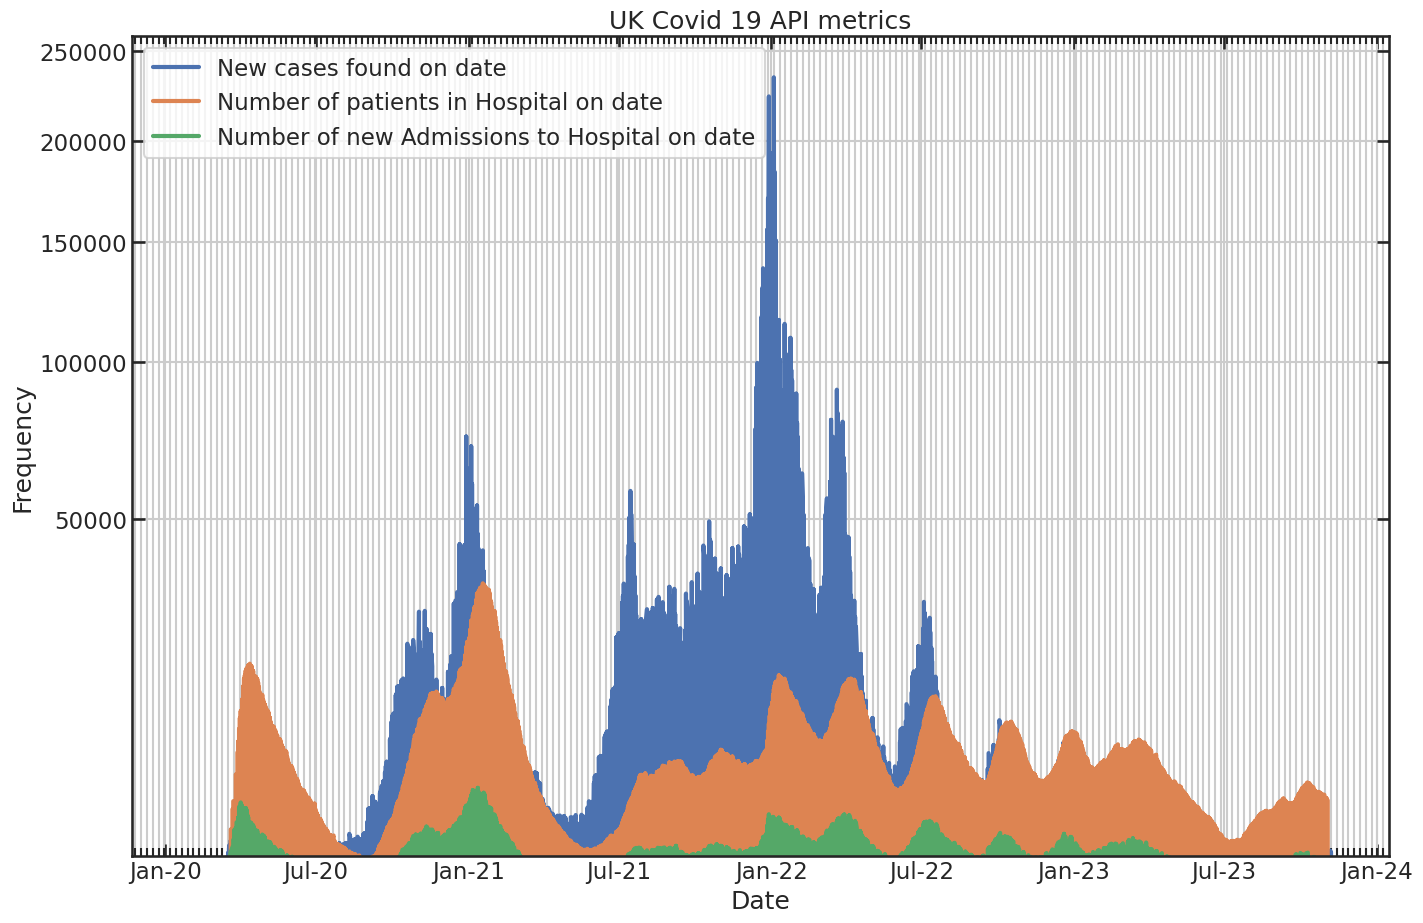

In [16]:
#create subplots
fig1, ax1 = plt.subplots(figsize=(15,10),sharex= True, facecolor='white')


#plot all the important parameters against the date
ax1.plot(df.index,df['Cases'],label='New cases found on date')
ax1.plot(df.index,df['Hospital'],label='Number of patients in Hospital on date')
ax1.plot(df.index,df['Admissions'],label='Number of new Admissions to Hospital on date')

#Lets give ticks on all 4 sides to the axes so that, we can infer that data more easily
ax1.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)

#Setting up a grid for clarity of the plot

ax1.grid(which='both')
ax1.set_xlabel('Date')
ax1.set_ylabel('Frequency')


# format the ticks

ax1.xaxis.set
ax1.xaxis.set_major_formatter(dateFmt)
ax1.xaxis.set_minor_locator(weeks)
#ax.set_xlim(left=dt.datetime(2021,7,1))
ax1.set_title('UK Covid 19 API metrics')
ax1.legend()


def forward(x):
    return x**(1/2)


def inverse(x):
    return x**2


ax1.set_yscale('function', functions=(forward, inverse))
_= fig.autofmt_xdate()

plt.tight_layout()

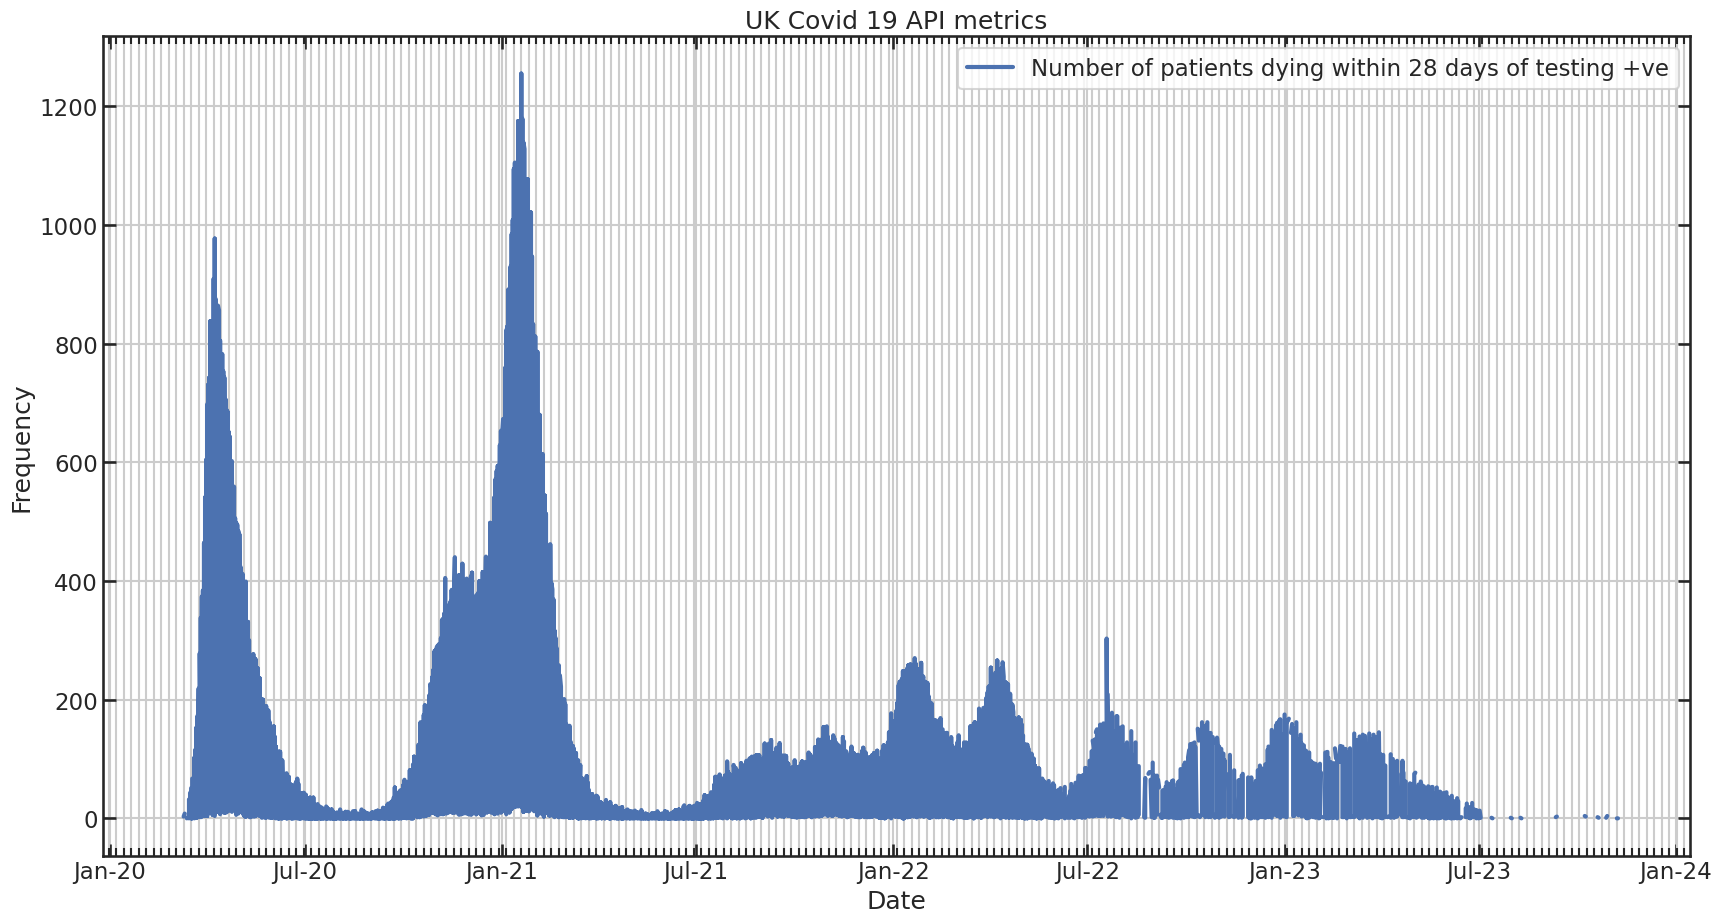

In [17]:
#create subplots
fig1, ax1 = plt.subplots(figsize=(18,10),sharex= True, facecolor='white')


#plot all the important parameters against the date
ax1.plot(df.index,df['Deaths'],label='Number of patients dying within 28 days of testing +ve')

#Lets give ticks on all 4 sides to the axes so that, we can infer that data more easily
ax1.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)

#Setting up a grid for clarity of the plot
ax1.grid(which='both')


ax1.set_xlabel('Date')
ax1.set_ylabel('Frequency')

# format the ticks


ax1.xaxis.set_major_formatter(dateFmt)
ax1.xaxis.set_minor_locator(weeks)
#ax.set_xlim(left=dt.datetime(2021,7,1))
ax1.set_title('UK Covid 19 API metrics')
ax1.legend()


_= fig.autofmt_xdate()

plt.tight_layout()

### Dataframe 2 : Google mobility metrics data

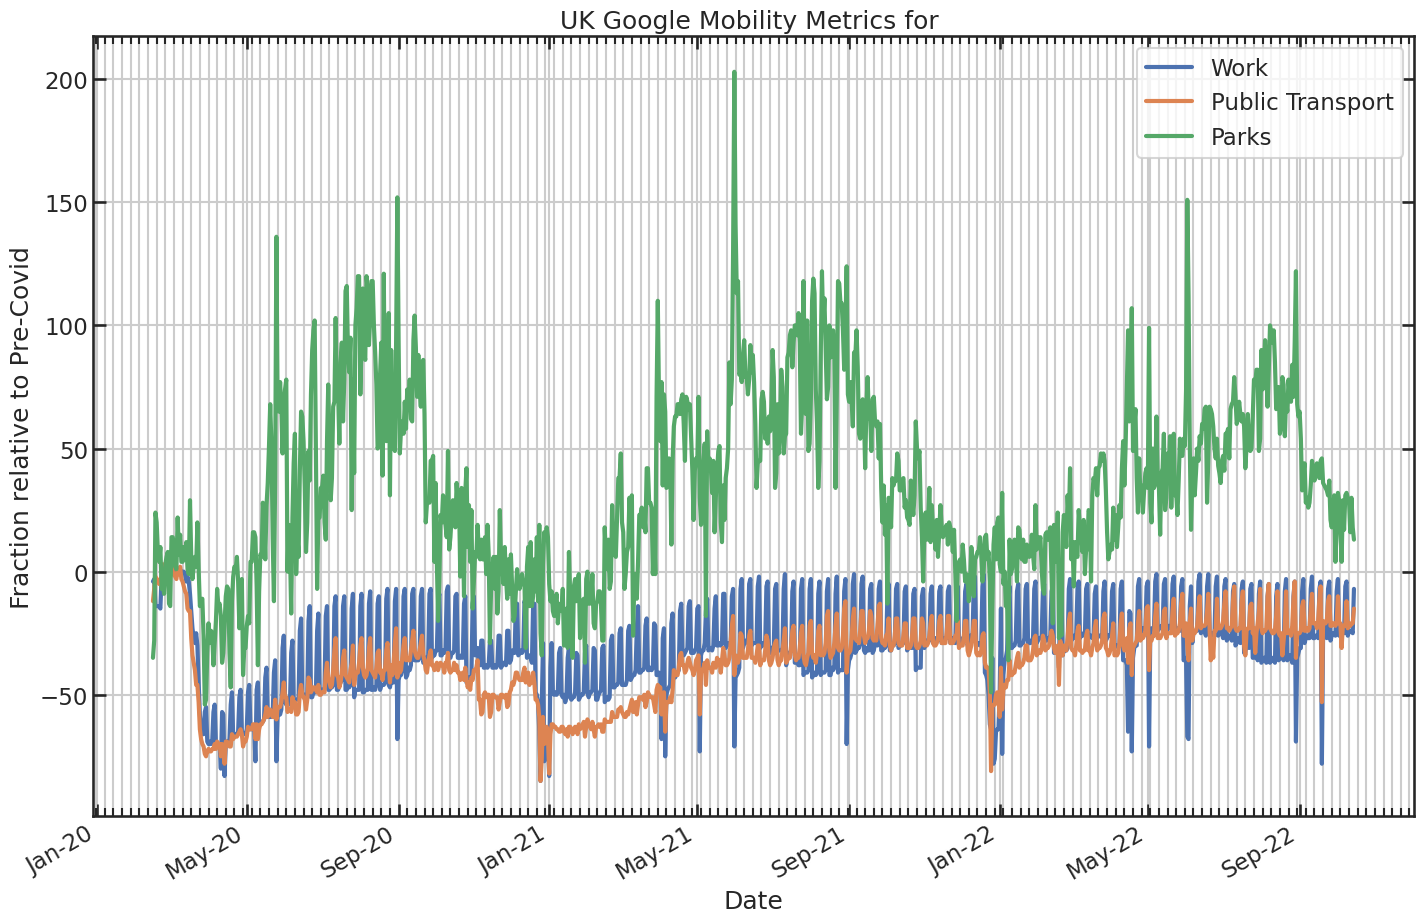

In [18]:
fig, ax = plt.subplots(figsize=(15,10),sharex= True, facecolor='white')

ax.plot(df_google.index,df_google['workplaces_percent_change_from_baseline'],label='Work')
ax.plot(df_google.index,df_google['transit_stations_percent_change_from_baseline'],label='Public Transport')
ax.plot(df_google.index,df_google['parks_percent_change_from_baseline'],label='Parks')

ax.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)

ax.grid(which='both')
ax.set_xlabel('Date')
ax.set_ylabel('Fraction relative to Pre-Covid')

# format the ticks


ax.xaxis.set_major_formatter(dateFmt)
ax.xaxis.set_minor_locator(weeks)
#ax.set_xlim(left=dt.datetime(2021,7,1))
ax.set_title('UK Google Mobility Metrics for ')
ax.legend()

_= fig.autofmt_xdate()

plt.tight_layout()
plt.savefig('mobility.png')

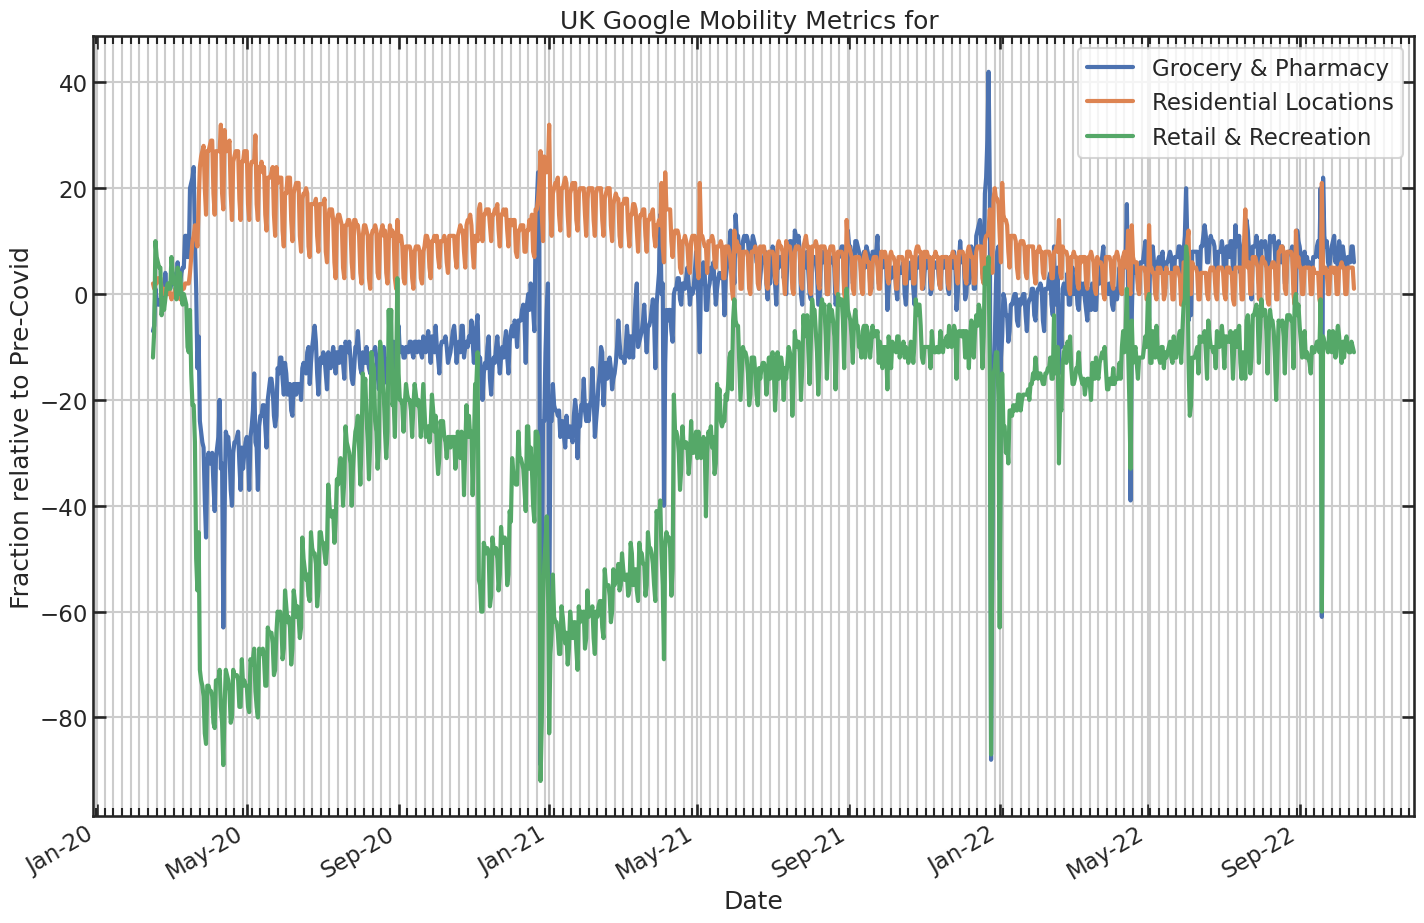

In [19]:
fig, ax = plt.subplots(figsize=(15,10),sharex= True, facecolor='white')


ax.plot(df_google.index,df_google['grocery_and_pharmacy_percent_change_from_baseline'],label='Grocery & Pharmacy')
ax.plot(df_google.index,df_google['residential_percent_change_from_baseline'],label='Residential Locations')
ax.plot(df_google.index,df_google['retail_and_recreation_percent_change_from_baseline'],label='Retail & Recreation')


ax.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)

ax.grid(which='both')
ax.set_xlabel('Date')
ax.set_ylabel('Fraction relative to Pre-Covid')

# format the ticks

ax.xaxis.set_major_formatter(dateFmt)
ax.xaxis.set_minor_locator(weeks)
#ax.set_xlim(left=dt.datetime(2021,7,1))
ax.set_title('UK Google Mobility Metrics for ')
ax.legend()

_= fig.autofmt_xdate()

plt.tight_layout()
plt.savefig('mobility.png')

<a name="processing"></a>

## 4. Data Preprocessing

### 4.1 Data Cleaning

#### First Dataframe, i.e. Cov19API , UK Cov19 casualties metrics ( df1 )

In [20]:
#As stated earlier, I will now change the name of this dataframe to df1

df1=df

df1.dropna()


#Dropping the na values, inorder to be able to get clean data which is needed to run most 
#machine learning and ARIMA models'" 


,Area type,Area name,Area code,Date,Cases,Hospital,Admissions,Deaths
Date,,,,,,,,
2020-03-18,nation,Northern Ireland,N92000002,2020-03-18,0.0,0.0,0.0,1.0
2020-03-19,nation,Northern Ireland,N92000002,2020-03-19,0.0,0.0,0.0,1.0
2020-03-20,nation,Northern Ireland,N92000002,2020-03-20,0.0,0.0,0.0,0.0
2020-03-20,nation,England,E92000001,2020-03-20,1096.0,1580.0,691.0,102.0
2020-03-21,nation,England,E92000001,2020-03-21,1040.0,2152.0,777.0,116.0
...,...,...,...,...,...,...,...,...
2023-07-08,nation,Wales,W92000004,2023-07-08,11.0,0.0,0.0,1.0
2023-07-09,nation,Wales,W92000004,2023-07-09,8.0,0.0,0.0,0.0
2023-07-10,nation,Wales,W92000004,2023-07-10,10.0,0.0,0.0,0.0


#### Second Dataframe, i.e. Google mobility metrics (df2)

In [21]:
#As stated earlier, I will now change the name of this dataframe to df2

df2=df_google

df2=df2.drop(columns=["sub_region_1","sub_region_2","iso_3166_2_code", "census_fips_code","metro_area"]) 
# dropping the columns with all NaN inorder to be able to get clean data which is needed to run most 
#machine learning and ARIMA models


df2.dropna()

#Dropping the na values, inorder to be able to get clean data which is needed to run most 
#machine learning and ARIMA models'" 



,country_region_code,country_region,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
date,,,,,,,,,,
2020-02-15,GB,United Kingdom,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-15,-12.0,-7.0,-35.0,-12.0,-4.0,2.0
2020-02-16,GB,United Kingdom,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-16,-7.0,-6.0,-28.0,-7.0,-3.0,1.0
2020-02-17,GB,United Kingdom,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-17,10.0,1.0,24.0,-2.0,-14.0,2.0
2020-02-18,GB,United Kingdom,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-18,7.0,-1.0,20.0,-3.0,-14.0,2.0
2020-02-19,GB,United Kingdom,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-19,6.0,-2.0,8.0,-4.0,-14.0,3.0
...,...,...,...,...,...,...,...,...,...,...
2022-10-11,GB,United Kingdom,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2022-10-11,-11.0,7.0,29.0,-21.0,-24.0,5.0
2022-10-12,GB,United Kingdom,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2022-10-12,-11.0,6.0,16.0,-22.0,-24.0,5.0
2022-10-13,GB,United Kingdom,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2022-10-13,-9.0,9.0,30.0,-21.0,-24.0,5.0


### 4.2 Reindexing the data

#### First Dataframe, i.e. Cov19API , UK Cov19 casualties metrics ( df1 )

In [22]:
df1.set_index(pd.to_datetime(df1['Date']),inplace=True)
#resetting the index of the dataframe

df1.sort_index(inplace=True)
#sorting the dataframe by our index, i.e. by date

df1['Date'] = pd.to_datetime(df1['Date'])

#### Second Dataframe, i.e. Google mobility metrics (df2)

In [23]:
df2.set_index(pd.to_datetime(df2['date']),inplace=True)
#resetting the index of the dataframe

df2.sort_index(inplace=True)
#sorting the dataframe by our index, i.e. by date

df2['date']=pd.to_datetime(df2['date'])


In [24]:
df2

,country_region_code,country_region,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
date,,,,,,,,,,
2020-02-15,GB,United Kingdom,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-15,-12.0,-7.0,-35.0,-12.0,-4.0,2.0
2020-02-16,GB,United Kingdom,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-16,-7.0,-6.0,-28.0,-7.0,-3.0,1.0
2020-02-17,GB,United Kingdom,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-17,10.0,1.0,24.0,-2.0,-14.0,2.0
2020-02-18,GB,United Kingdom,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-18,7.0,-1.0,20.0,-3.0,-14.0,2.0
2020-02-19,GB,United Kingdom,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-19,6.0,-2.0,8.0,-4.0,-14.0,3.0
...,...,...,...,...,...,...,...,...,...,...
2022-10-11,GB,United Kingdom,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2022-10-11,-11.0,7.0,29.0,-21.0,-24.0,5.0
2022-10-12,GB,United Kingdom,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2022-10-12,-11.0,6.0,16.0,-22.0,-24.0,5.0
2022-10-13,GB,United Kingdom,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2022-10-13,-9.0,9.0,30.0,-21.0,-24.0,5.0


### 4.3 Resampling


#### First Dataframe, i.e. Cov19API , UK Cov19 casualties metrics ( df1 )

In [25]:
# resampling the data by days, as we had more than one value for the same day
# we use the sum method here which accumulates the values like a bin in a histogram
# the argument D specifies days, Date specifies the index column and closed specifies the side of the bin 
dfresampled=df1.resample("D", on="Date", closed="right").sum()

dfresampled = df1

df1



,Area type,Area name,Area code,Date,Cases,Hospital,Admissions,Deaths
Date,,,,,,,,
2020-01-30,nation,England,E92000001,2020-01-30,1.0,NaN,NaN,NaN
2020-01-31,nation,England,E92000001,2020-01-31,0.0,NaN,NaN,NaN
2020-02-01,nation,England,E92000001,2020-02-01,0.0,NaN,NaN,NaN
2020-02-02,nation,England,E92000001,2020-02-02,1.0,NaN,NaN,NaN
2020-02-03,nation,England,E92000001,2020-02-03,18.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-11-06,nation,England,E92000001,2023-11-06,740.0,NaN,NaN,NaN
2023-11-07,nation,England,E92000001,2023-11-07,681.0,NaN,NaN,NaN
2023-11-07,nation,Wales,W92000004,2023-11-07,18.0,NaN,NaN,0.0


#### Second Dataframe, i.e. Google mobility metrics (df2)

In [26]:
df2resampled=df2.resample("D", on="date", closed="right").sum()

df2resampled = df2

In [27]:
df2

,country_region_code,country_region,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
date,,,,,,,,,,
2020-02-15,GB,United Kingdom,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-15,-12.0,-7.0,-35.0,-12.0,-4.0,2.0
2020-02-16,GB,United Kingdom,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-16,-7.0,-6.0,-28.0,-7.0,-3.0,1.0
2020-02-17,GB,United Kingdom,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-17,10.0,1.0,24.0,-2.0,-14.0,2.0
2020-02-18,GB,United Kingdom,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-18,7.0,-1.0,20.0,-3.0,-14.0,2.0
2020-02-19,GB,United Kingdom,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2020-02-19,6.0,-2.0,8.0,-4.0,-14.0,3.0
...,...,...,...,...,...,...,...,...,...,...
2022-10-11,GB,United Kingdom,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2022-10-11,-11.0,7.0,29.0,-21.0,-24.0,5.0
2022-10-12,GB,United Kingdom,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2022-10-12,-11.0,6.0,16.0,-22.0,-24.0,5.0
2022-10-13,GB,United Kingdom,ChIJqZHHQhE7WgIReiWIMkOg-MQ,2022-10-13,-9.0,9.0,30.0,-21.0,-24.0,5.0


### 4.4 Filtering Data

#### We filter df1 to get data for dates till which we have data in both the dataframes, this is done to combine them later.

#### I chose not to interpolate and extrapolate to not lose accuracy of my model later

In [28]:
df1=df1['2020-02-15':'2022-10-15'] 

# because we only have df2 till this date
#I do not want to extrapolate.... 
#I believe as extrapolating could 
#decrease the efficiency of my model later
#In addition, there seem to be sufficient data points still

### 4.5 Merging the 2 data frames (df3)

In [29]:
# First let me rename the date of df1, so that both df1 and df2 have the same index

df1.rename(columns={"Date": "date"}, inplace=True)

/tmp/ipykernel_8879/4099406550.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.rename(columns={"Date": "date"}, inplace=True)


In [30]:
#Here, I use pd.concat to merge the 2 dataframes df1 and df2

df3=pd.concat([df1,df2])

In [31]:
#Lets have a look at our new beautiful dataframe
df3 

,Area type,Area name,Area code,date,Cases,Hospital,Admissions,Deaths,country_region_code,country_region,place_id,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
2020-02-15,nation,England,E92000001,2020-02-15,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-16,nation,England,E92000001,2020-02-16,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-17,nation,England,E92000001,2020-02-17,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-18,nation,England,E92000001,2020-02-18,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-19,nation,England,E92000001,2020-02-19,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-11,NaN,NaN,NaN,2022-10-11,NaN,NaN,NaN,NaN,GB,United Kingdom,ChIJqZHHQhE7WgIReiWIMkOg-MQ,-11.0,7.0,29.0,-21.0,-24.0,5.0
2022-10-12,NaN,NaN,NaN,2022-10-12,NaN,NaN,NaN,NaN,GB,United Kingdom,ChIJqZHHQhE7WgIReiWIMkOg-MQ,-11.0,6.0,16.0,-22.0,-24.0,5.0
2022-10-13,NaN,NaN,NaN,2022-10-13,NaN,NaN,NaN,NaN,GB,United Kingdom,ChIJqZHHQhE7WgIReiWIMkOg-MQ,-9.0,9.0,30.0,-21.0,-24.0,5.0
2022-10-14,NaN,NaN,NaN,2022-10-14,NaN,NaN,NaN,NaN,GB,United Kingdom,ChIJqZHHQhE7WgIReiWIMkOg-MQ,-10.0,9.0,18.0,-21.0,-25.0,5.0


In [32]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4834 entries, 2020-02-15 to 2022-10-15
Data columns (total 17 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   Area type                                           3860 non-null   object        
 1   Area name                                           3860 non-null   object        
 2   Area code                                           3860 non-null   object        
 3   date                                                4834 non-null   datetime64[ns]
 4   Cases                                               3711 non-null   float64       
 5   Hospital                                            3751 non-null   float64       
 6   Admissions                                          3744 non-null   float64       
 7   Deaths                                              3507 non-null   float64   

<a name="define"></a>

# 5. Defining the problem

Having looked at the data, having finally gotten a merged dataset and having understood the data that we have at hand now, fully,

It is time to face the elephant in the room,

What is the problem that we now wish to solve from this data?

A major problem which was faced during the time was to forecast 7 days in advance as to how many beds would be required by the hospitals.


I will try to forecast this by taking,

Output variable as the hospital column


and Input variable would be the mobility through all 5 metrics that we have received.

Hence, now it is time to get rid of the irrelevant columns here and finally filter our data

But first, I will try to predict it using a simple ARIMA model on the Hospital data

In [33]:
df4=df3[["date","Admissions","retail_and_recreation_percent_change_from_baseline","grocery_and_pharmacy_percent_change_from_baseline","parks_percent_change_from_baseline","transit_stations_percent_change_from_baseline","workplaces_percent_change_from_baseline","residential_percent_change_from_baseline"]].resample("D", on="date", closed="right").sum()

In [34]:
df4

,Admissions,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
date,,,,,,,
2020-02-14,0.0,-12.0,-7.0,-35.0,-12.0,-4.0,2.0
2020-02-15,0.0,-7.0,-6.0,-28.0,-7.0,-3.0,1.0
2020-02-16,0.0,10.0,1.0,24.0,-2.0,-14.0,2.0
2020-02-17,0.0,7.0,-1.0,20.0,-3.0,-14.0,2.0
2020-02-18,0.0,6.0,-2.0,8.0,-4.0,-14.0,3.0
...,...,...,...,...,...,...,...
2022-10-10,1244.0,-11.0,7.0,29.0,-21.0,-24.0,5.0
2022-10-11,1192.0,-11.0,6.0,16.0,-22.0,-24.0,5.0
2022-10-12,1277.0,-9.0,9.0,30.0,-21.0,-24.0,5.0


<a name="arima"></a>

# 6. ARIMA model


An ARIMA model or an Autoregressive Integrated Moving Average model, is a combination of 
an Auto regressive(AR) model and a Moving Average(MA) model


#### Key~ Reference 6: https://campus.datacamp.com/courses/arima-models-in-python/arma-models-1?ex=9

**AR model** ( Auto-regressive model ) :-
Regress the timeseries against the value of the shock/noise in the previous step plus the shock/noise in the present term.

It takes previous values of the timeseries at t-1 or t-2 and models them to forecast the values, while incorporating the shock terms.
A simple 1st order AR model would be
AR(1) :-  $ y_{t} = a_{1}*y_{t-1}+ \epsilon_{t} $
Here, a is the coefficient and the slope of line and $ \epsilon_{t} $ is the shock term with residual noise.
Similarly, AR(2) :-  $ y_{t} = a_{1}*y_{t-1}+ a_{2}*y_{t-2}+ \epsilon_{t} $

**MA model** ( Moving Average model ) :-
Takes a floating average of 7 days or a month of data and makes predictions based on it.

First order MA model is represented as MA(1) :-  $ y_{t} = m_{1}*\epsilon_{t-1}+ \epsilon_{t}$
It is a product of m1 and shock term at a previous time, added to shock term at current time.

**ARIMA model** is an integration of AR and MA models, while automatically incorporating for the non-stationarity of data, by taking differences between the values.

It is usually written as ARIMA(df, order=(p,d,q))

where p - number of autoregressive lags (t-1, t-2,....)

      d - order of differencing (df[i]-df[i-1])
 
      q - number of moving average lags ( shock term lags e.g. 
      $ \epsilon_{t-1}+\epsilon_{t} $ )
      
If d i.e. differencing is 0, then we simply have an ARMA model.





## 6.1 Data Visualisation 

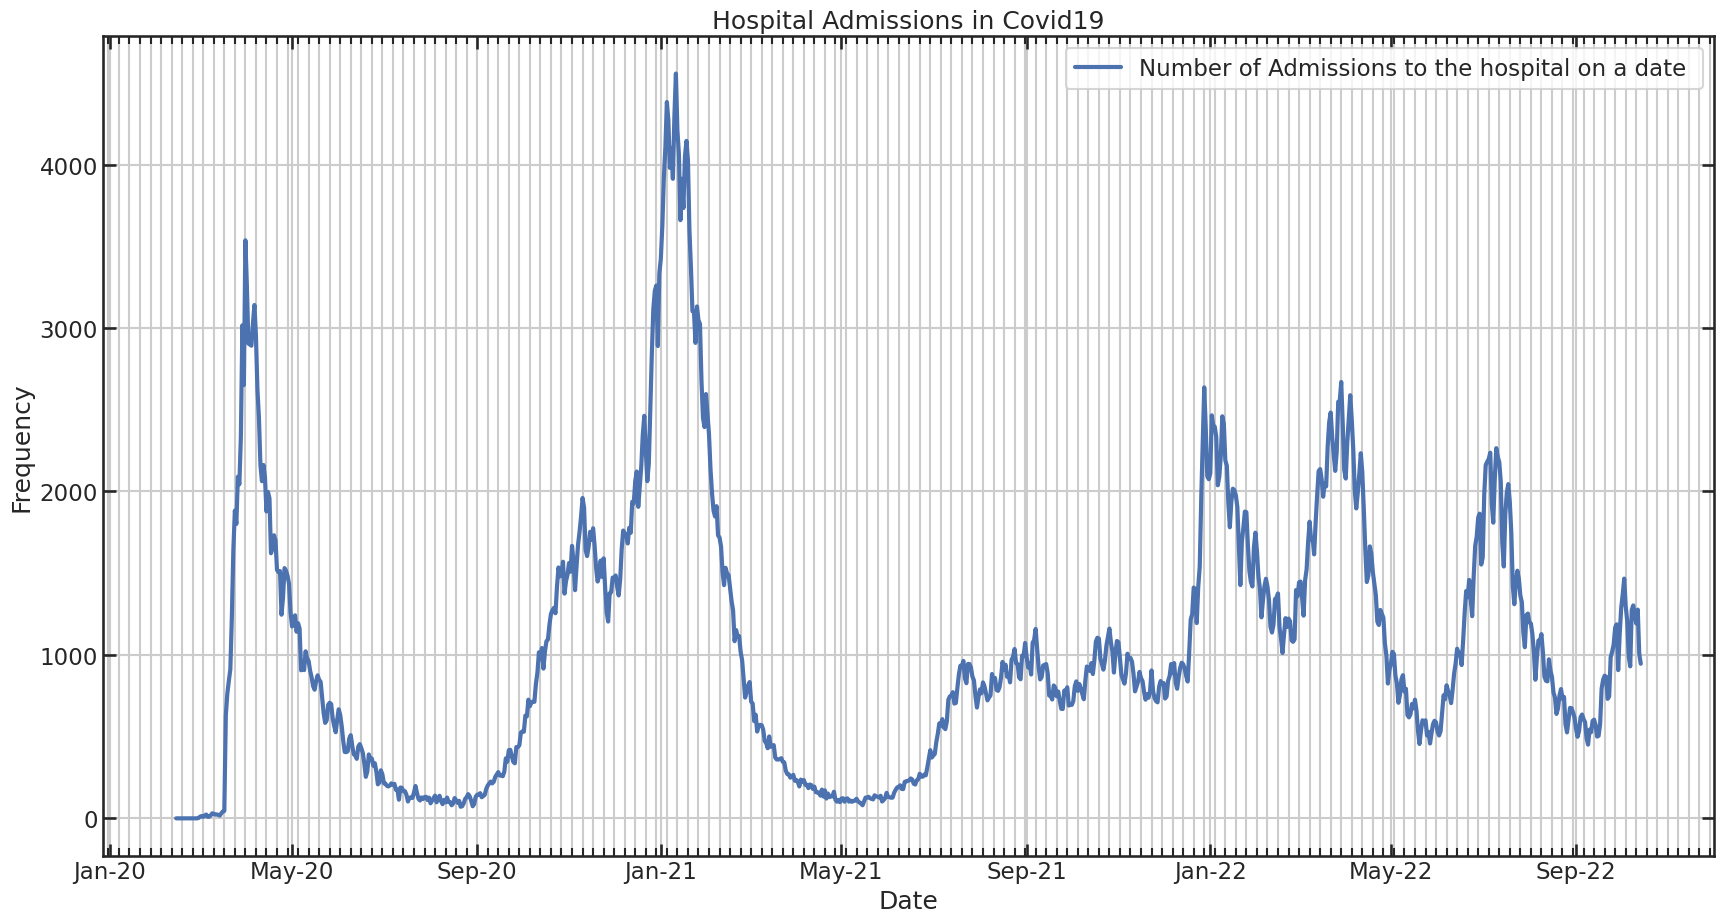

In [35]:
#create subplots
fig1, ax1 = plt.subplots(figsize=(18,10),sharex= True, facecolor='white')


#plot all the important parameters against the date
ax1.plot(df4.index,df4['Admissions'],label='Number of Admissions to the hospital on a date ')

#Lets give ticks on all 4 sides to the axes so that, we can infer that data more easily
ax1.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)

#Setting up a grid for clarity of the plot
ax1.grid(which='both')


ax1.set_xlabel('Date')
ax1.set_ylabel('Frequency')

#format the ticks

ax1.xaxis.set_major_formatter(dateFmt)
ax1.xaxis.set_minor_locator(weeks)
#ax.set_xlim(left=dt.datetime(2021,7,1))
ax1.set_title('Hospital Admissions in Covid19')
ax1.legend()


_= fig.autofmt_xdate()

plt.tight_layout()

## 6.2 Split the data into training and test sets

In [36]:
df4_train=df4["Admissions"].loc[:'2022-05-15']

In [37]:
df4_test=df4["Admissions"].loc['2022-05-16':]

In [38]:
df4_test

date
2022-05-16     673.0
2022-05-17     726.0
2022-05-18     659.0
2022-05-19     535.0
2022-05-20     455.0
               ...  
2022-10-10    1244.0
2022-10-11    1192.0
2022-10-12    1277.0
2022-10-13    1006.0
2022-10-14     946.0
Freq: D, Name: Admissions, Length: 152, dtype: float64

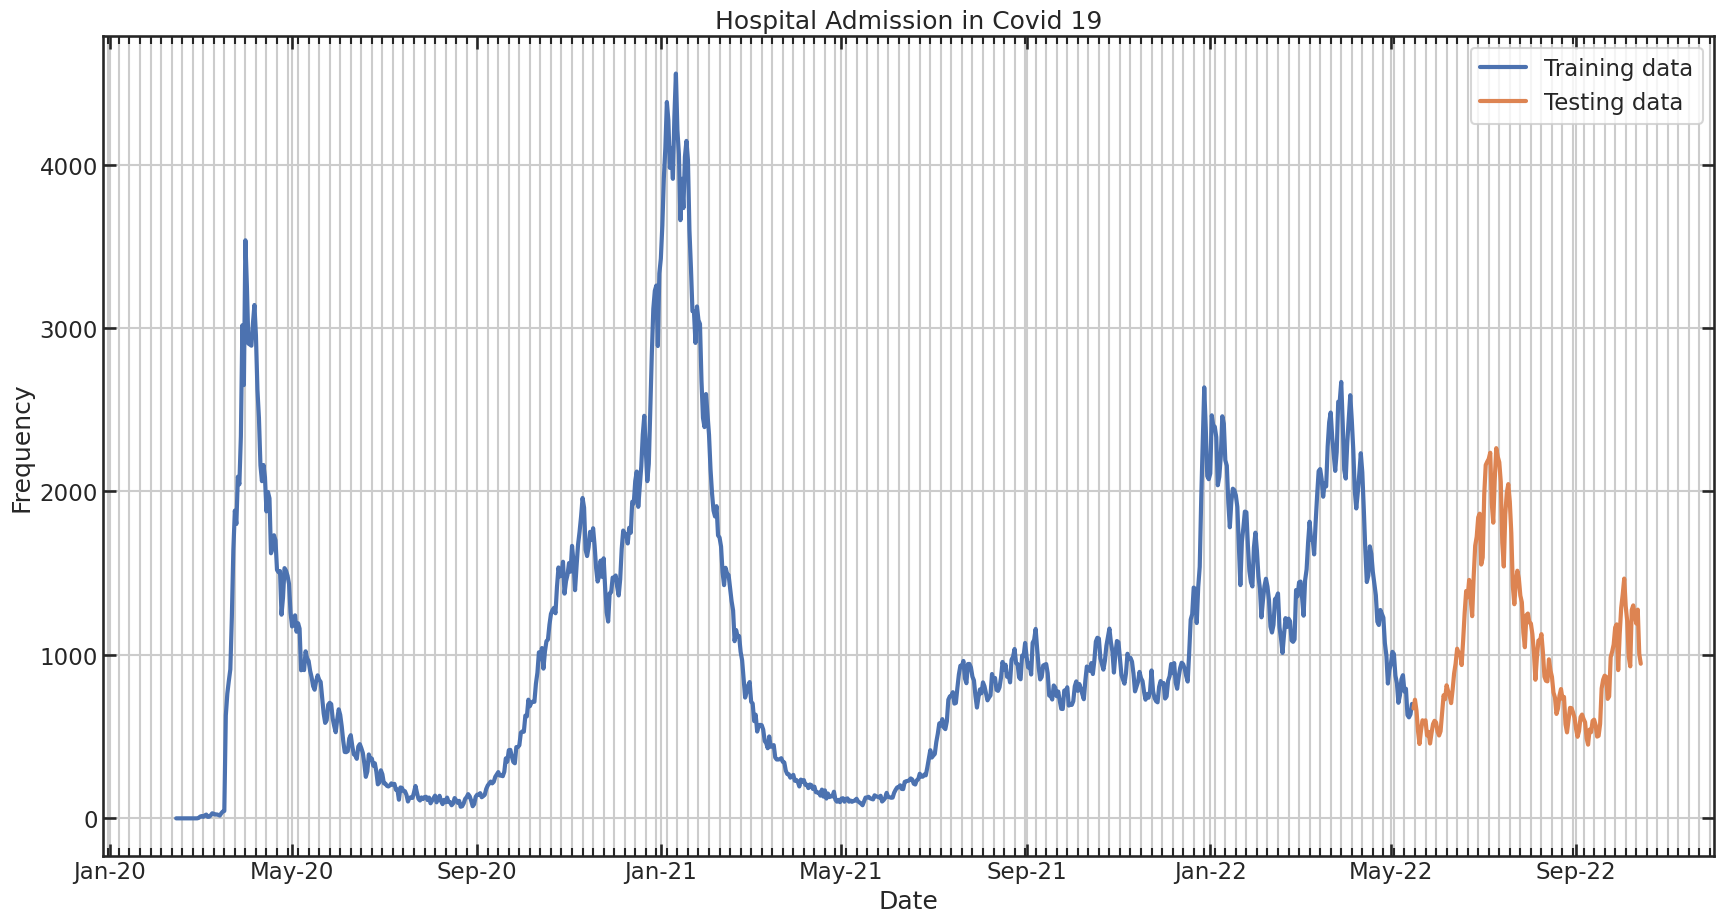

In [39]:
#create subplots
fig1, ax1 = plt.subplots(figsize=(18,10),sharex= True, facecolor='white')

#plot all the important parameters against the date
ax1.plot(df4_train.index,df4_train,label='Training data')
ax1.plot(df4_test.index,df4_test,label='Testing data ')

#Lets give ticks on all 4 sides to the axes so that, we can infer that data more easily
ax1.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)

#Setting up a grid for clarity of the plot
ax1.grid(which='both')


ax1.set_xlabel('Date')
ax1.set_ylabel('Frequency')

#format the ticks

ax1.xaxis.set_major_formatter(dateFmt)
ax1.xaxis.set_minor_locator(weeks)
#ax.set_xlim(left=dt.datetime(2021,7,1))
ax1.set_title('Hospital Admission in Covid 19')
ax1.legend()


_= fig.autofmt_xdate()

plt.tight_layout()

## 6.3 Check for Stationarity

Non-Stationarity is a common problem with time series data.
Stationarity of the data is important to run ARMA models over it.
Stationarity implies:
1. The series has no trend 
2. Constant variance
3. Autocorrelation is constant ( How the values in dataset are relative to neighbours is constant)

*From the plot, the data seems stationary*

But, lets be precise,

We can check for stationarity by the augmented dicky-fuller test

We use the adfuller function for the same,

it will give back an array

1) 0th element of array -> test-statistic (more -ve more stationary)
2) 1st element of array -> p-value
3) 4th element -> critical test statistics

In [40]:
#Importing the adfuller function
from statsmodels.tsa.stattools import adfuller

#running the adfuller function to check for stationarity
result=adfuller(df4["Admissions"])

In [41]:
print(result)

(-3.765711909255043, 0.0032782672819068387, 22, 951, {'1%': -3.4372448882473177, '5%': -2.86458394997689, '10%': -2.5683907715382888}, 11335.8913527324)


Hence, since the data has a very -ve test statistic for a very low p value, hence, the data is stationary and we do not need to transform it to make it stationary

In [42]:
#Importing the ARIMA model

from statsmodels.tsa.arima.model import ARIMA


In [43]:
#Building the model

model = ARIMA(df4["Admissions"], order=(1,0,1))

In [44]:
# Fitting the model

results = model.fit()

In [45]:
#Getting the results

print(results.summary())

                               SARIMAX Results                                
Dep. Variable:             Admissions   No. Observations:                  974
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -6014.865
Date:                Sun, 12 Nov 2023   AIC                          12037.731
Time:                        23:13:04   BIC                          12057.257
Sample:                    02-14-2020   HQIC                         12045.161
                         - 10-14-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1046.3336    374.776      2.792      0.005     311.785    1780.882
ar.L1          0.9870      0.004    261.529      0.000       0.980       0.994
ma.L1          0.1526      0.016      9.434      0.0

In [46]:
#Forecasting the results for test data

forecast=results.get_prediction(start="2022-05-16", end="2022-10-14")

In [47]:
#Getting the mean values of the forecasts for the respective days, as forecast usually gives the difference

mean_forecast=forecast.predicted_mean

In [48]:
# Since this forecast is in the form of Series, we will convert it into a dataframe, to later attach it back
df5=mean_forecast.to_frame()

# Lets have a look at our beautiful dataframe now
df5

,predicted_mean
date,
2022-05-16,713.180594
2022-05-17,671.710185
2022-05-18,738.440770
2022-05-19,651.899902
2022-05-20,523.791311
...,...
2022-10-10,1296.287562
2022-10-11,1233.455939
2022-10-12,1183.783554


In [49]:
# Lets merge this dataframe with our training dataframe to be able to make a beauriful visualisation 

df6=pd.concat([df5, df4_train])

### Data visualisation of our new plot containing training, test and predicted data

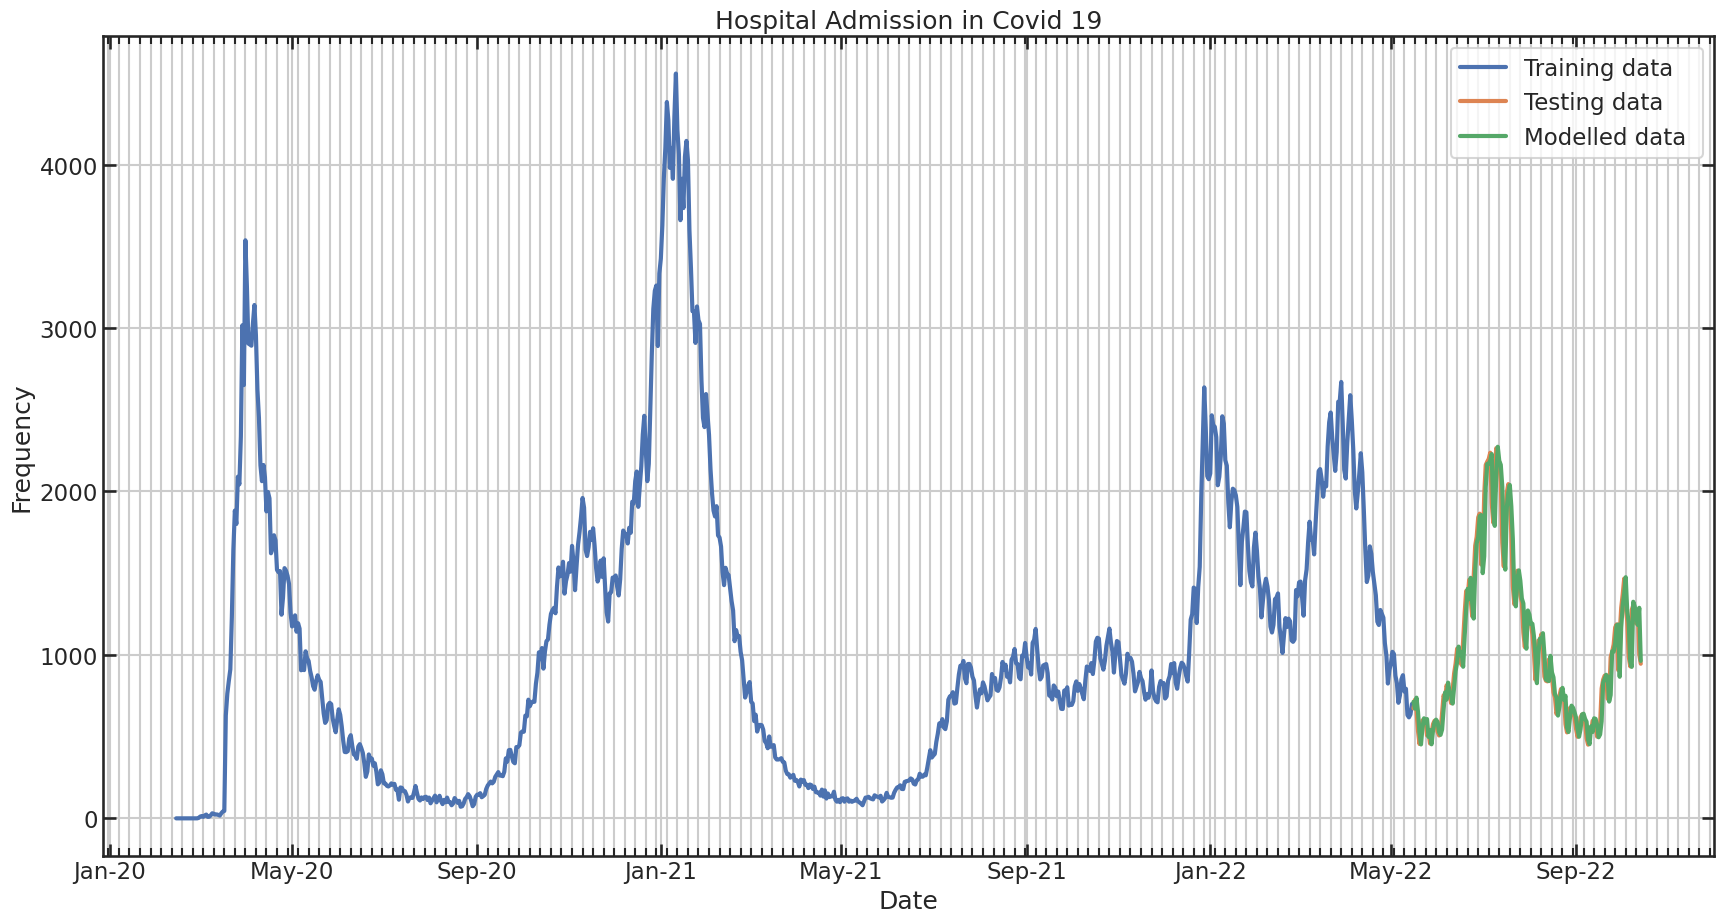

In [50]:
#create subplots
fig2, ax2 = plt.subplots(figsize=(18,10),sharex= True, facecolor='white')


#plot all the important parameters against the date
ax2.plot(df4_train.index,df4_train,label='Training data')
ax2.plot(df4_test.index,df4_test,label='Testing data ')
ax2.plot(df6.index,df6["predicted_mean"],label='Modelled data ')


#Lets give ticks on all 4 sides to the axes so that, we can infer that data more easily
ax2.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)

#Setting up a grid for clarity of the plot
ax2.grid(which='both')


ax2.set_xlabel('Date')
ax2.set_ylabel('Frequency')

#format the ticks

ax2.xaxis.set_major_formatter(dateFmt)
ax2.xaxis.set_minor_locator(weeks)
#ax.set_xlim(left=dt.datetime(2021,7,1))
ax2.set_title('Hospital Admission in Covid 19')
ax2.legend()


_= fig.autofmt_xdate()

plt.tight_layout()



Hence, the model does an ok job at predicting the future values of Hospital Admissions

But, let us now, find the best ARIMA model possible

<a name="model"></a> 

## 7. Finding the best ARIMA model

When it comes to ARIMA modelling, 

we have only 3 features to optimize,

p, i.e. the auto-regressive model coefficient

d, i.e. the difference to take from the former date.

q, i.e. the moving average model coefficient


Since our data is already stationary, as verified, by the dicky fuller test, we took earlier,
we can put our d to be 0,

hence, we will only need to optimise for p and d

Now, **What are the parameters to judge how good an ARIMA model is performing?**

They are,

**AIC and BIC

"AIC - Akaike Information Criterion

A model which makes better predictions is given a lower AIC score,

It also, prefers a simple model to avoid overfitting to the training data " -
##### Key Reference 7: 
https://campus.datacamp.com/courses/arima-models-in-python/the-best-of-the-best-models?ex=4


BIC - Bayesian Information Criterion

It works nearly like AIC



let us now, write a code which will loop through the different values of p and q to fit over our data and then compare their performances using AIC and BIC metrics, to choose which ARIMA model is performing the best.

In [51]:
# Loop over p values from 0-2
for p in range(3):
    # Loop over q values from 0-2
    for q in range(3):
      
        try:
            # create and fit ARMA(p,q) model
            model = ARIMA(df4["Admissions"], order=(p,0,q))
            results = model.fit()
            
            # Print order and results
            print(p, q, results.aic, results.bic)
            
        except:
            print(p, q, None, None)     

0 0 15881.82080552126 15891.583628128545


/home/rj23/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


0 1 14686.541243179143 14701.18547709007


/home/rj23/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


0 2 13909.362781327107 13928.888426541676
1 0 12060.047068658376 12074.691302569303
1 1 12037.730887923644 12057.256533138214
1 2 12034.946130500965 12059.353187019176
2 0 12036.458097491724 12055.983742706294
2 1 12038.44345639294 12062.850512911153
2 2 12028.19605073498 12057.484518556836


Apparently, 

for ARIMA(1,0,1) model, the efficiency does not improve very significantly for an increase in model complexity and a very high model complexity may simply lead the model to over fit.

Hence, I will choose the model ARIMA(1,0,1) itself.


Thankfully, it was my initial guess as well, hence I do not need to rerun the model to get a good value.

### 7.1 Measuring the performance of our model

Lets compare our predictions with the test data

We will do this using a parameter, Root Mean Squared Error,
which measures the mean of the square of the distance of the target value from the predictor value, and take its square root.

In [52]:
# Lets import mean squared error

from sklearn.metrics import mean_squared_error

In [53]:
# note the amount of error
# we use squared = false to take RMSE and not MSE
error= mean_squared_error(df4_test,df5["predicted_mean"], squared= False)

In [54]:
print(error)

14184.646537658306


## 8. Conclusion

<a name="conclusion"></a> 

Hence, my model does a reasonable job at predicting the number of admissions in hospital for future dates.

A development of the model further, could be to use ARMAX models or to use multivariate regression.

I will do the same on a future date, however I hope the purpose of this assignment has been fulfilled as I have compared several models and fitted the best one, describing my thought process for the same.

## 9. References

<a name="references"></a> 

1. https://coronavirus.data.gov.uk/details/
2. https://coronavirus.data.gov.uk/details/developers-guide/main-api
3. https://coronavirus.data.gov.uk/metrics
4. https://www.google.com/covid19/mobility/
5. https://www.google.com/covid19/mobility/
6. https://www.datacamp.com

</pre>



<h1><center> EXTRA WORK </center></h1>


</pre>

## 10. Extra Work

In the following code,

I will use Scikit Learn to make a linear regression model and will also attempt to find the best possible model and features using Lasso and Ridge Regression.

## 10.1 Multiple Linear Regression


It is perhaps one of the simplest models,
We make a linear model, between one output variable and one or more predictor input variables, also known as features.

It is represented as,

y = aX + b

 y is target, X is a vector of predictors, a is a vector of coefficients and b is coefficient to be minimised. a is slope and b is intercept for a simple linear regression.

Residual sum of squares is the loss function which we try to minimize here, which is basically the squared distance between the prediction of the target and the actual values of the target variable.

We will also, test the efficiency of our model by using the most important metric of model performance, which is R-squared.

R-squared explains the amount of variance in our target variables with respect to our predictor variables. Varying from 0 to 1. A high R-squared value represents a better model.

Mean Squared Error, which measures the mean of the square of the distance of the target value from the predictor value can also be used.

However, we will use Root Mean Squared Error to get the root of MSE to get a better value, however, both error functions can be used and are appropriate


In [64]:
# Importing Linear Regression and train test splitter 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


# Let us get the data we will need
X = df4.drop("Admissions", axis=1).values
Y = df4["Admissions"].values



# let us now split the training and test data
# here, test_size determines, how much test data we need,
#random_state acts exactly as random_seed, i.e. produces a unique set of random numbers for train test split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=6)


# Creating  model
model = LinearRegression()

#fitting the model
model.fit(X_train, Y_train)

# Precting the y values
Y_pred = model.predict(X_test)

# Lets print a random actual value, and predicted value just to look at our model
print("Predictions: {}, Actual Values: {}".format(Y_pred[15], Y_test[15]))


# Compute R-squared
r_squared = model.score(X_test, Y_test)

# Compute RMSE
rmse = mean_squared_error(Y_test, Y_pred, squared=False)

# Print the metrics
print("R^2: {}".format(r_squared))
print("RMSE: {}".format(rmse))

Predictions: 1568.1893392588133, Actual Values: 1377.0
R^2: 0.2890466465596936
RMSE: 644.5437879639738


Hence, the model does an ok job of predicting the values of the target variables.

Let us tune the model performance using various techniques, as follows

### 10.2  Regularized Regression

It is a technique of regression used to avoid overfitting of our linear regression model.
In linear regression, as we discussed, we minimise, RSS function, however, the coefficients of our model may become too large and this may lead to overfitting. Hence, in regularised regression, we penalise overfitting of our models


#### Ridge Regression

It is a model which we use to penalise models with large positive or negative coefficients

It is represented as 

$  \alpha \sum_{i=1}^{n} a_{i}^2 $

Here, if the alpha value gets very large, the model may overfit,

hence, we use this to get models with optimised $ R^2 $ values



In [65]:
# Import Ridge
from sklearn.linear_model import Ridge
alphas = [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
ridge_scores = []
for alpha in alphas:
  
  # Create a Ridge regression model
  ridge = Ridge(alpha=alpha)
  
  # Fit the data
  ridge.fit(X_train, Y_train)
  
  # Obtain R-squared
  score = ridge.score(X_test, Y_test)
  ridge_scores.append(score)
print(ridge_scores)




[0.2890472916211978, 0.2890530864693439, 0.2891099861715082, 0.28958422105233383, 0.29000822618306676, 0.2778374891794635]


Hence, we loose model performance for values of alpha greater than, 1000


#### Lasso Regression

It is a regression technique which we use to choose features which are most important for the model.

It is represented as 
$  \alpha \sum_{i=1}^{n} a_{i}^2 $

where, the value of alpha shrinks to zero as we add more and more unimportant features to the model.


In [73]:
# Import Lasso
from sklearn.linear_model import Lasso

# Instantiate a lasso regression model
lasso = Lasso(alpha=1000)

# Fit the model to the data
lasso.fit(X,Y)

# Compute and print the coefficients
lasso_coef = lasso.coef_
print(-lasso_coef)



[ 0.          0.          9.47916848  2.16785559  7.5870643  -0.        ]


Hence, 3rd, 4th and 5th columns from the features are the most important features for our regression model,

Lets have a look at the features to find which are these.

In [77]:
df4

,Admissions,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
date,,,,,,,
2020-02-14,0.0,-12.0,-7.0,-35.0,-12.0,-4.0,2.0
2020-02-15,0.0,-7.0,-6.0,-28.0,-7.0,-3.0,1.0
2020-02-16,0.0,10.0,1.0,24.0,-2.0,-14.0,2.0
2020-02-17,0.0,7.0,-1.0,20.0,-3.0,-14.0,2.0
2020-02-18,0.0,6.0,-2.0,8.0,-4.0,-14.0,3.0
...,...,...,...,...,...,...,...
2022-10-10,1244.0,-11.0,7.0,29.0,-21.0,-24.0,5.0
2022-10-11,1192.0,-11.0,6.0,16.0,-22.0,-24.0,5.0
2022-10-12,1277.0,-9.0,9.0,30.0,-21.0,-24.0,5.0


### 10.3 Conclusion

Hence, park_percent_change from baseline, transit_stations_percent_change_from_baseline	workplaces_percent_change_from_baseline are the most important features here.

This also tells us that, inorder to decrease hospital admissions, 

the government should focus on policies which will first decrease the commute to parks, followed by workplaces and then finally transit stations.